In [380]:
import spike.spike_analysis.spike_collection as sc
import spike.spike_analysis.spike_recording as sr
import spike.spike_analysis.firing_rate_calculations as fr
import spike.spike_analysis.normalization as norm
import spike.spike_analysis.single_cell as single_cell
import spike.spike_analysis.spike_collection as collection
import spike.spike_analysis.zscoring as zscoring
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import behavior.boris_extraction as boris
import matplotlib.pyplot as plt
import pickle
import re

In [381]:
pd.set_option('display.max_colwidth', 0)  # 0 means unlimited in newer pandas versions

# Show all rows
pd.set_option("display.max_rows", None)

# Show all columns
pd.set_option("display.max_columns", None)

# Don’t truncate column contents
pd.set_option("display.max_colwidth", None)

# Expand the display to the full width of the screen
pd.set_option("display.width", 0)


In [382]:
spike_collection_json_path = r'C:\Users\thoma\Code\ResearchCode\diff_fam_social_memory_ephys\spike_collection.json\spike_collection.json'

In [383]:
import importlib
importlib.reload(sc)
importlib.reload(zscoring)

<module 'spike.spike_analysis.zscoring' from 'c:\\Users\\thoma\\Code\\ResearchCode\\diff_fam_social_memory_ephys\\spike\\spike_analysis\\zscoring.py'>

In [384]:
sp = sc.SpikeCollection.load_collection(spike_collection_json_path)

In [385]:
rec_events = sp.recordings[0].event_dict

# get unique event names from rec_events dictionary
event_names = list(rec_events.keys())
print("Unique event names:", event_names)

Unique event names: ['alone_rewarded', 'alone_rewarded_baseline', 'high_comp', 'high_comp_lose', 'high_comp_lose_baseline', 'high_comp_win', 'high_comp_win_baseline', 'lose', 'low_comp', 'low_comp_lose', 'low_comp_lose_baseline', 'low_comp_win', 'low_comp_win_baseline', 'overall_pretone', 'win']


#### Unique event names: ['alone_rewarded', 'alone_rewarded_baseline', 'high_comp', 'high_comp_lose', 'high_comp_lose_baseline', 'high_comp_win', 'high_comp_win_baseline', 'lose', 'low_comp', 'low_comp_lose', 'low_comp_lose_baseline', 'low_comp_win', 'low_comp_win_baseline', 'overall_pretone', 'win']


### Make sure it's in timestamps not ms

In [386]:
# Pick any one recording and unit
recording = sp.recordings[0]  # or choose a specific one
unit_id = list(recording.unit_timestamps.keys())[0]  # get the first available good unit

# Extract the raw spike timestamps
raw_spikes = recording.unit_timestamps[unit_id]

# Show the first few spikes
print(f"Raw spike timestamps for unit {unit_id}:")
print(raw_spikes[:10])

# Convert to milliseconds
converted_spikes_ms = raw_spikes * (1000 / recording.sampling_rate)
print("\nConverted to milliseconds:")
print(converted_spikes_ms[:10])

# Also print min/max to check range
print(f"\nMin raw spike: {raw_spikes.min()} | Max raw spike: {raw_spikes.max()}")
print(f"Min spike time in ms: {converted_spikes_ms.min():.2f} ms | Max: {converted_spikes_ms.max():.2f} ms")


Raw spike timestamps for unit 104:
[276153 503505 649539 686660 752824 757488 768359 782699 783787 820039]

Converted to milliseconds:
[13807.65 25175.25 32476.95 34333.   37641.2  37874.4  38417.95 39134.95
 39189.35 41001.95]

Min raw spike: 276153 | Max raw spike: 68111594
Min spike time in ms: 13807.65 ms | Max: 3405579.70 ms


#### Z-Score for an event using baselines of all events in a recording

In [387]:
import numpy as np
import pandas as pd

def run_zscore_global_baseline(recording, event_name, pre_window=10, SD=1.65, verbose=False):
    """
    Z-score event firing rates using a *pooled* baseline (all event types) per unit.
    This function calculates the z-score of firing rates for a specific event type
    based on a global baseline computed from all event types in the recording.
    Parameters:
    - recording: SpikeRecording object containing spike data and events.
    - event_name: Name of the event type to analyze.
    - pre_window: Duration in seconds before the event to use for baseline calculation.
    - SD: Number of standard deviations to use for significance thresholding.
    - verbose: If True, prints additional information during processing.
    Returns:
    - A pandas DataFrame containing the z-scores and significance of firing rates for each unit
    for the specified event type.
    """
    # Step 1: Pool all baseline windows across all events for each unit
    global_baseline_counts = {}
    units = getattr(recording, "good_units", None)
    if units is None:
        units = [unit_id for unit_id, label in recording.labels_dict.items() if label == "good"]

    # Initialize global baseline list per unit
    for unit_id in units:
        global_baseline_counts[unit_id] = []

    # Loop through all event types and pool all baselines
    for ev_type, event_windows in recording.event_dict.items():
        for unit_id in units:
            spikes = recording.unit_timestamps[unit_id]
            spikes_ms = spikes * (1000 / recording.sampling_rate)
            for window in event_windows:
                start_event = window[0]
                start_baseline = start_event - int(pre_window * 1000)
                end_baseline = start_event
                baseline_count = np.sum((spikes_ms >= start_baseline) & (spikes_ms < end_baseline))
                global_baseline_counts[unit_id].append(baseline_count)

    # Step 2: Compute global baseline mean and SD per unit
    baseline_mean = {u: np.mean(c) for u, c in global_baseline_counts.items()}
    baseline_sd = {u: np.std(c) for u, c in global_baseline_counts.items()}

    # Step 3: For the target event, calculate z-scores
    event_windows = recording.event_dict[event_name]
    event_firing = {}
    rows = []
    for unit_id in units:
        spikes = recording.unit_timestamps[unit_id]
        spikes_ms = spikes * (1000 / recording.sampling_rate)
        event_counts = []
        for window in event_windows:
            start_event = window[0]
            end_event = window[1]
            event_count = np.sum((spikes_ms >= start_event) & (spikes_ms < end_event))
            event_counts.append(event_count)

        ev_mean = np.mean(event_counts)
        b_mean = baseline_mean[unit_id]
        b_sd = baseline_sd[unit_id]

        zscore = np.nan if b_sd == 0 else (ev_mean - b_mean) / b_sd

        sig = "not sig"
        if not np.isnan(zscore):
            if zscore > SD:
                sig = "increase"
            elif zscore < -SD:
                sig = "decrease"

        rows.append({
            "Recording": recording.name,
            "Event name": event_name,
            "Unit number": unit_id,
            "Global Pre-event M": b_mean,
            "Global Pre-event SD": b_sd,
            "Event M": ev_mean,
            "Event Z-Score": zscore,
            "sig": sig
        })

    df = pd.DataFrame(rows)
    return df


In [388]:
rec = sp.recordings[0]
event_name = "alone_rewarded"  # or any event you know exists

df = run_zscore_global_baseline(rec, event_name, pre_window=10, SD=1.65)
df.head(20)

,Recording,Event name,Unit number,Global Pre-event M,Global Pre-event SD,Event M,Event Z-Score,sig
0,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,104,0.939130,1.459821,0.75,-0.129557,not sig
1,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,11,3.191304,4.476306,2.70,-0.109757,not sig
2,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,122,1.434783,3.471325,1.85,0.119614,not sig
3,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,125,10.554348,8.245900,6.90,-0.443171,not sig
4,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,126,43.439130,33.150621,32.15,-0.340541,not sig
5,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,130,0.686957,0.926567,1.05,0.391816,not sig
6,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,143,10.991304,12.726894,9.70,-0.101463,not sig
7,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,147,0.371739,1.175319,0.60,0.194212,not sig
8,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,158,3.400000,4.478062,5.70,0.513615,not sig
9,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,189,19.228261,9.698614,18.15,-0.111177,not sig


In [ ]:
alone_rewarded_df = zscoring.run_zscore_global_baseline(rec, event_name, pre_window=10, SD=1.65, verbose=True)
alone_rewarded_df.head(30)

[RunZScore] Running for 20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec, event: alone_rewarded, pre_window=10s, SD threshold=1.65
[GlobalBaseline] Found 22 good units in recording 20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
[GlobalBaseline] Processing event type: alone_rewarded, 40 windows
[GlobalBaseline] Unit 104: n_baseline=40, example_counts=[np.int64(0), np.int64(1), np.int64(3), np.int64(0), np.int64(0), np.int64(2), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
[GlobalBaseline] Unit 11: n_baseline=40, example_counts=[np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(3), np.int64(1), np.int64(3)]
[GlobalBaseline] Unit 122: n_baseline=40, example_counts=[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
[GlobalBaseline] Unit 125: n_baseline=40, example_counts=[np.int64(21), np.int64(4), n

,Recording,Event name,Unit number,Global Baseline M,Global Baseline SD,Event M,Event Z-Score,sig
0,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,104,0.75,1.042833,0.75,0.000000,not sig
1,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,11,2.50,2.906888,2.70,0.068802,not sig
2,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,122,0.60,1.356466,1.85,0.921512,not sig
3,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,125,7.45,7.200521,6.90,-0.076383,not sig
4,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,126,40.10,25.238661,32.15,-0.314993,not sig
5,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,130,0.55,0.668954,1.05,0.747435,not sig
6,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,143,8.50,10.466614,9.70,0.114650,not sig
7,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,147,0.30,0.900000,0.60,0.333333,not sig
8,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,158,1.90,2.586503,5.70,1.469165,not sig
9,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,189,18.55,12.245305,18.15,-0.032666,not sig


In [405]:
# get all unique event names from the recording
event_names = list(rec.event_dict.keys())
print("Unique event names in recording:", event_names)

Unique event names in recording: ['alone_rewarded', 'alone_rewarded_baseline', 'high_comp', 'high_comp_lose', 'high_comp_lose_baseline', 'high_comp_win', 'high_comp_win_baseline', 'lose', 'low_comp', 'low_comp_lose', 'low_comp_lose_baseline', 'low_comp_win', 'low_comp_win_baseline', 'overall_pretone', 'win']


In [406]:
high_comp_df = zscoring.run_zscore_global_baseline(rec, "high_comp", pre_window=10, SD=1.65, verbose=True)
high_comp_df.head(30)

[RunZScore] Running for 20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec, event: high_comp, pre_window=10s, SD threshold=1.65
[GlobalBaseline] Found 22 good units in recording 20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
[GlobalBaseline] Processing event type: high_comp, 9 windows
[GlobalBaseline] Unit 104: n_baseline=9, example_counts=[np.int64(7), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
[GlobalBaseline] Unit 11: n_baseline=9, example_counts=[np.int64(4), np.int64(7), np.int64(9), np.int64(11), np.int64(27), np.int64(2), np.int64(5), np.int64(25), np.int64(2)]
[GlobalBaseline] Unit 122: n_baseline=9, example_counts=[np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
[GlobalBaseline] Unit 125: n_baseline=9, example_counts=[np.int64(4), np.int64(2), np.int64(10), np.int64(10), np.int64(4), np.int64(9),

,Recording,Event name,Unit number,Global Baseline M,Global Baseline SD,Event M,Event Z-Score,sig
0,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp,104,0.777778,2.199888,0.333333,-0.202031,not sig
1,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp,11,10.222222,8.904154,8.444444,-0.199657,not sig
2,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp,122,0.444444,0.496904,0.666667,0.447214,not sig
3,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp,125,6.666667,4.320494,9.888889,0.745800,not sig
4,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp,126,9.444444,9.776515,11.666667,0.227302,not sig
5,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp,130,0.222222,0.415740,0.222222,0.000000,not sig
6,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp,143,21.111111,13.851951,21.555556,0.032085,not sig
7,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp,147,0.555556,1.257079,0.777778,0.176777,not sig
8,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp,158,1.000000,1.414214,3.444444,1.728483,increase
9,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp,189,6.000000,4.027682,9.777778,0.937953,not sig


In [407]:
high_comp_win_df = zscoring.run_zscore_global_baseline(rec, "high_comp_win", pre_window=10, SD=1.65, verbose=True)
high_comp_win_df.head(30)

[RunZScore] Running for 20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec, event: high_comp_win, pre_window=10s, SD threshold=1.65
[GlobalBaseline] Found 22 good units in recording 20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
[GlobalBaseline] Processing event type: high_comp_win, 8 windows
[GlobalBaseline] Unit 104: n_baseline=8, example_counts=[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
[GlobalBaseline] Unit 11: n_baseline=8, example_counts=[np.int64(7), np.int64(9), np.int64(11), np.int64(27), np.int64(2), np.int64(5), np.int64(25), np.int64(2)]
[GlobalBaseline] Unit 122: n_baseline=8, example_counts=[np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
[GlobalBaseline] Unit 125: n_baseline=8, example_counts=[np.int64(2), np.int64(10), np.int64(10), np.int64(4), np.int64(9), np.int64(15), np.int64(5), np.int64(1)]
[Gl

,Recording,Event name,Unit number,Global Baseline M,Global Baseline SD,Event M,Event Z-Score,sig
0,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp_win,104,0.000,0.000000,0.250,NaN,not sig
1,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp_win,11,11.000,9.151503,9.500,-0.163908,not sig
2,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp_win,122,0.500,0.500000,0.750,0.500000,not sig
3,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp_win,125,7.000,4.472136,10.625,0.810575,not sig
4,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp_win,126,10.500,9.874209,12.625,0.215207,not sig
5,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp_win,130,0.250,0.433013,0.250,0.000000,not sig
6,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp_win,143,21.250,14.686303,23.625,0.161715,not sig
7,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp_win,147,0.625,1.316957,0.875,0.189832,not sig
8,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp_win,158,1.000,1.500000,3.625,1.750000,increase
9,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp_win,189,5.875,4.255511,9.875,0.939958,not sig


In [408]:
high_comp_lose_df = zscoring.run_zscore_global_baseline(rec, "high_comp_lose", pre_window=10, SD=1.65, verbose=True)
high_comp_lose_df.head(30)

[RunZScore] Running for 20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec, event: high_comp_lose, pre_window=10s, SD threshold=1.65
[GlobalBaseline] Found 22 good units in recording 20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
[GlobalBaseline] Processing event type: high_comp_lose, 1 windows
[GlobalBaseline] Unit 104: n_baseline=1, example_counts=[np.int64(7)]
[GlobalBaseline] Unit 11: n_baseline=1, example_counts=[np.int64(4)]
[GlobalBaseline] Unit 122: n_baseline=1, example_counts=[np.int64(0)]
[GlobalBaseline] Unit 125: n_baseline=1, example_counts=[np.int64(4)]
[GlobalBaseline] Unit 126: n_baseline=1, example_counts=[np.int64(1)]
[GlobalBaseline] Unit 130: n_baseline=1, example_counts=[np.int64(0)]
[GlobalBaseline] Unit 143: n_baseline=1, example_counts=[np.int64(20)]
[GlobalBaseline] Unit 147: n_baseline=1, example_counts=[np.int64(0)]
[GlobalBaseline] Unit 158: n_baseline=1, example_counts=[np.int64(1)]
[GlobalBaseline] Uni

,Recording,Event name,Unit number,Global Baseline M,Global Baseline SD,Event M,Event Z-Score,sig
0,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp_lose,104,7.0,0.0,1.0,NaN,not sig
1,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp_lose,11,4.0,0.0,0.0,NaN,not sig
2,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp_lose,122,0.0,0.0,0.0,NaN,not sig
3,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp_lose,125,4.0,0.0,4.0,NaN,not sig
4,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp_lose,126,1.0,0.0,4.0,NaN,not sig
5,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp_lose,130,0.0,0.0,0.0,NaN,not sig
6,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp_lose,143,20.0,0.0,5.0,NaN,not sig
7,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp_lose,147,0.0,0.0,0.0,NaN,not sig
8,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp_lose,158,1.0,0.0,2.0,NaN,not sig
9,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,high_comp_lose,189,7.0,0.0,9.0,NaN,not sig


### zscore for an event using only the baselines for that event type

In [390]:
def run_zscore_per_event(recording, event_name, pre_window=10, SD=1.65, verbose=False):
    """
    For each 'good' unit, computes spike counts in event and pre-event baseline windows (in ms),
    runs z-scoring, and returns a DataFrame of results.

    Parameters:
    - recording: SpikeRecording object containing unit timestamps and event windows.
    - event_name: Name of the event to analyze (must be in recording.event_dict).
    - duration: Duration of the event window in seconds.
    - pre_window: Duration of the pre-event baseline window in seconds.
    - SD: Number of standard deviations for significance threshold in z-scoring.
    - verbose: If True, print debugging information.
    Returns:
    - A DataFrame with z-scored firing rates for each unit and event window.
    """
    event_windows = recording.event_dict[event_name]  # event dict values for the event time windows
    event_firing = {}
    baseline_firing = {}

    # Use .good_units if available, otherwise fallback to your original logic
    units = getattr(recording, "good_units", None)
    if units is None:
        units = [unit_id for unit_id, label in recording.labels_dict.items() if label == "good"]
    for unit_id in units:
        spikes = recording.unit_timestamps[unit_id]
        if verbose:
            print(f"\nConverting spikes for unit: {unit_id}\n")

        # Convert spike timestamps to milliseconds if needed
        spikes_ms = spikes * (1000 / recording.sampling_rate)

        event_counts = []
        baseline_counts = []
        for window in event_windows:
            start_event = window[0]
            end_event = window[1]

            if verbose:
                print(f"\nEvent window: {start_event}, {end_event} for unit {unit_id}\n")

            start_baseline = start_event - int(pre_window * 1000)
            end_baseline = start_event

            # Count spikes in each window
            event_count = np.sum((spikes_ms >= start_event) & (spikes_ms < end_event))
            baseline_count = np.sum((spikes_ms >= start_baseline) & (spikes_ms < end_baseline))

            event_counts.append(event_count)
            baseline_counts.append(baseline_count)

        if len(event_counts) == len(event_windows) and len(baseline_counts) == len(event_windows):
            event_firing[unit_id] = np.array(event_counts)
            baseline_firing[unit_id] = np.array(baseline_counts)

            if verbose:
                print(f"\nUnit {unit_id} - Event counts: {event_counts}, Baseline counts: {baseline_counts}\n")
        else:
            if verbose:
                print(f"\n\n---Skipping unit {unit_id} due to mismatched counts: {len(event_counts)} vs {len(event_windows)}---\n")

    # Filter out empty entries
    event_firing = {k: v for k, v in event_firing.items() if v.shape and v.shape[0] > 0}
    baseline_firing = {k: v for k, v in baseline_firing.items() if v.shape and v.shape[0] > 0}

    if verbose:
        print(f"\nevent_firing units: {len(event_firing)}")
        print(f"baseline_firing units: {len(baseline_firing)}\n")

    if not event_firing or not baseline_firing:
        if verbose:
            print("\n------------------------------------\nERROR: No valid units for z-scoring because of empty firing rates for all units.\n-------------------------------\n")
        return pd.DataFrame()

    # --- REPLACED RESULT-BUILDING SECTION ---
    rows = []

    for unit in event_firing:
        event_vals = event_firing[unit]
        baseline_vals = baseline_firing[unit]

        ev_mean = np.mean(event_vals)
        baseline_mean = np.mean(baseline_vals)
        baseline_sd = np.std(baseline_vals)

        if baseline_sd == 0:
            zscore = np.nan
        else:
            zscore = (ev_mean - baseline_mean) / baseline_sd

        sig = "not sig"
        if not np.isnan(zscore):
            if zscore > SD:
                sig = "increase"
            elif zscore < -SD:
                sig = "decrease"

        rows.append({
            "Recording": recording.name,
            "Event name": event_name,
            "Unit number": unit,
            "Pre-event M": baseline_mean,
            "Pre-event SD": baseline_sd,
            "Event M": ev_mean,
            "Event Z-Score": zscore,
            "sig": sig
        })

    df = pd.DataFrame(rows)
    return df


## Z-Score per event, use to compare to across all events z-score function to make sure it's working or to see if there's a difference

In [391]:
rec = sp.recordings[0]
event_name = "alone_rewarded"  # or any event you know exists

df = run_zscore_per_event(rec, event_name, pre_window=10, SD=1.65)
df.head(20)

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig
0,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,104,0.75,1.042833,0.75,0.000000,not sig
1,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,11,2.50,2.906888,2.70,0.068802,not sig
2,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,122,0.60,1.356466,1.85,0.921512,not sig
3,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,125,7.45,7.200521,6.90,-0.076383,not sig
4,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,126,40.10,25.238661,32.15,-0.314993,not sig
5,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,130,0.55,0.668954,1.05,0.747435,not sig
6,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,143,8.50,10.466614,9.70,0.114650,not sig
7,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,147,0.30,0.900000,0.60,0.333333,not sig
8,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,158,1.90,2.586503,5.70,1.469165,not sig
9,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,189,18.55,12.245305,18.15,-0.032666,not sig


### verbose version of z-score per event

In [392]:
recording = sp.recordings[0]
event_name = "alone_rewarded"  # or any event you know exists

zscore_df = run_zscore_per_event(recording, event_name, pre_window=10, SD=1.65, verbose=True)
zscore_df.head(20)



Converting spikes for unit: 104


Event window: 1849109.9, 1859109.9 for unit 104


Event window: 1909109.85, 1919109.95 for unit 104


Event window: 1964109.8, 1974109.9 for unit 104


Event window: 2029109.75, 2039109.75 for unit 104


Event window: 2084109.85, 2094109.7 for unit 104


Event window: 2134109.8, 2144109.7 for unit 104


Event window: 2184109.75, 2194109.75 for unit 104


Event window: 2289109.55, 2299109.65 for unit 104


Event window: 2409109.6, 2419109.6 for unit 104


Event window: 2529109.4, 2539109.4 for unit 104


Event window: 2639109.3, 2649109.3 for unit 104


Event window: 2724109.35, 2734109.35 for unit 104


Event window: 2844109.3, 2854109.15 for unit 104


Event window: 2904109.1, 2914109.1 for unit 104


Event window: 2969109.05, 2979109.15 for unit 104


Event window: 3029109.15, 3039109.0 for unit 104


Event window: 3104108.95, 3114109.1 for unit 104


Event window: 3204108.9, 3214109.0 for unit 104


Event window: 3299108.95, 3309108.8 for unit 104


,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig
0,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,104,0.75,1.042833,0.75,0.000000,not sig
1,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,11,2.50,2.906888,2.70,0.068802,not sig
2,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,122,0.60,1.356466,1.85,0.921512,not sig
3,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,125,7.45,7.200521,6.90,-0.076383,not sig
4,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,126,40.10,25.238661,32.15,-0.314993,not sig
5,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,130,0.55,0.668954,1.05,0.747435,not sig
6,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,143,8.50,10.466614,9.70,0.114650,not sig
7,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,147,0.30,0.900000,0.60,0.333333,not sig
8,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,158,1.90,2.586503,5.70,1.469165,not sig
9,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,189,18.55,12.245305,18.15,-0.032666,not sig


## Z-scoring for all recordings for alone_rewarded | Probably incorrect since it only finds baseline for singular recording instead of across all

In [393]:
# loop through all recordings for 'alone_rewarded' event
all_zscore_dfs = []
for recording in sp.recordings:
    if 'alone_rewarded' in recording.event_dict:
        zscore_df = run_zscore_per_event(recording, 'alone_rewarded', pre_window=10, SD=1.65, verbose=False)
        if not zscore_df.empty:
            all_zscore_dfs.append(zscore_df)
# Combine all DataFrames into one
if all_zscore_dfs:
    combined_zscore_df = pd.concat(all_zscore_dfs, ignore_index=True)
    print("\nCombined Z-Score DataFrame for 'alone_rewarded' event:\n")
    print(combined_zscore_df.head(20))
else:
    print("\nNo valid z-score data found for 'alone_rewarded' event across recordings.\n")


Combined Z-Score DataFrame for 'alone_rewarded' event:

                                                                      Recording  \
0   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
1   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
2   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
3   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
4   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
5   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
6   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
7   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
8   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
9   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
10  20230612_101430_standard_c

In [394]:
# show head of combined DataFrame wit column Event name == high_comp
if 'Event name' in combined_zscore_df.columns:
    high_comp_df = combined_zscore_df[combined_zscore_df['Event name'] == 'high_comp_win']
    print("\nCombined Z-Score DataFrame for 'high_comp' event:\n")
    print(high_comp_df.head(20))


Combined Z-Score DataFrame for 'high_comp' event:

Empty DataFrame
Columns: [Recording, Event name, Unit number, Pre-event M, Pre-event SD, Event M, Event Z-Score, sig]
Index: []


In [395]:
# Create new z-score DataFrame for every event and recording
event_zscore_dfs = {}
for recording in sp.recordings:
    for event_name in recording.event_dict.keys():
        zscore_df = run_zscore_per_event(recording, event_name, pre_window=10, SD=1.65, verbose=False)
        if not zscore_df.empty:
            if event_name not in event_zscore_dfs:
                #print(f"{event_name} not in event_zscore_dfs, creating new list")
                event_zscore_dfs[event_name] = []
            #print(f"Appending zscore_df for event '{event_name}' from recording '{recording.name}'")
            event_zscore_dfs[event_name].append(zscore_df)
# Combine all DataFrames for each event into one
combined_event_zscore_dfs = {}
for event_name, dfs in event_zscore_dfs.items():
    #print(f"Combining {len(dfs)} DataFrames for event '{event_name}'")
    # Check if there are any DataFrames to combine
    if dfs:
        combined_event_zscore_dfs[event_name] = pd.concat(dfs, ignore_index=True)
# Print combined DataFrames for each event
for event_name, df in combined_event_zscore_dfs.items():
    print(f"\nCombined Z-Score DataFrame for '{event_name}' event:\n")
    print(df.head(20))

# create one DataFrame with all events and their z-scores
all_events_combined_df = pd.concat(combined_event_zscore_dfs.values(), ignore_index=True)



Combined Z-Score DataFrame for 'alone_rewarded' event:

                                                                      Recording  \
0   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
1   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
2   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
3   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
4   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
5   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
6   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
7   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
8   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
9   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
10  20230612_101430_standard_c

In [396]:
all_events_combined_df.tail(20)

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig
6671,20240323_144517_alone_comp_subj_3-4_t6b6_merged.rec,high_comp_tie,32,39.0,6.0,64.0,4.166667,increase
6672,20240323_144517_alone_comp_subj_3-4_t6b6_merged.rec,high_comp_tie,4,157.5,2.5,150.0,-3.000000,decrease
6673,20240323_144517_alone_comp_subj_3-4_t6b6_merged.rec,high_comp_tie,7,3.5,0.5,1.5,-4.000000,decrease
6674,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_tie,0,11.0,5.0,51.5,8.100000,increase
6675,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_tie,12,0.0,0.0,0.5,NaN,not sig
6676,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_tie,18,86.0,11.0,107.5,1.954545,increase
6677,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_tie,24,6.5,2.5,59.5,21.200000,increase
6678,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_tie,25,1.5,0.5,1.5,0.000000,not sig
6679,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_tie,27,314.0,43.0,303.0,-0.255814,not sig
6680,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_tie,4,20.5,8.5,5.5,-1.764706,decrease


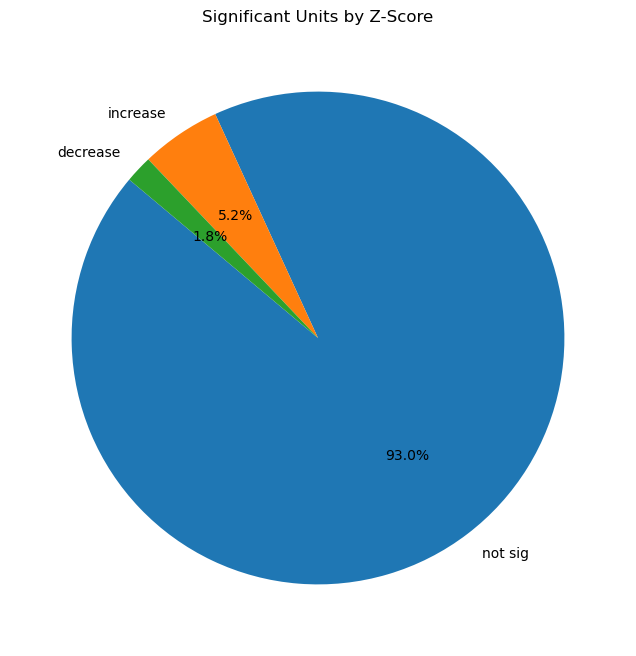

In [397]:
# create pie chart of significant units
def plot_significant_units(df):
    """
    Plots a pie chart of significant units based on z-scores.
    """
    if df.empty:
        print("No data to plot.")
        return

    # Count occurrences of each significance level
    sig_counts = df['sig'].value_counts()

    # Create pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(sig_counts, labels=sig_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Significant Units by Z-Score')
    plt.show()
# Plot significant units for the combined DataFrame
plot_significant_units(all_events_combined_df)

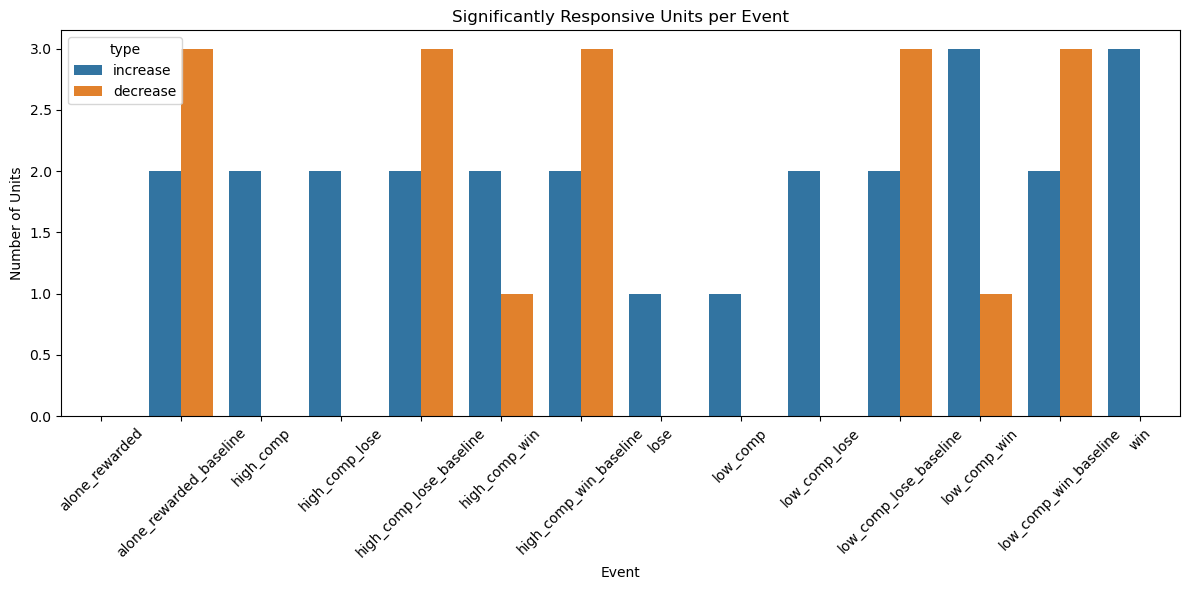

In [398]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine all z-scored DataFrames across events
event_names = ['alone_rewarded', 'alone_rewarded_baseline', 'high_comp', 'high_comp_lose', 'high_comp_lose_baseline', 'high_comp_win', 'high_comp_win_baseline', 'lose', 'low_comp', 'low_comp_lose', 'low_comp_lose_baseline', 'low_comp_win', 'low_comp_win_baseline', 'win']

summary_rows = []

for event in event_names:
    zscore_df = run_zscore_per_event(recording, event, pre_window=10, SD=1.65)
    if not zscore_df.empty:
        inc = (zscore_df["sig"] == "increase").sum()
        dec = (zscore_df["sig"] == "decrease").sum()
        summary_rows.append({'event': event, 'type': 'increase', 'count': inc})
        summary_rows.append({'event': event, 'type': 'decrease', 'count': dec})

summary_df = pd.DataFrame(summary_rows)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=summary_df, x='event', y='count', hue='type')
plt.xticks(rotation=45)
plt.title('Significantly Responsive Units per Event')
plt.ylabel('Number of Units')
plt.xlabel('Event')
plt.tight_layout()
plt.show()


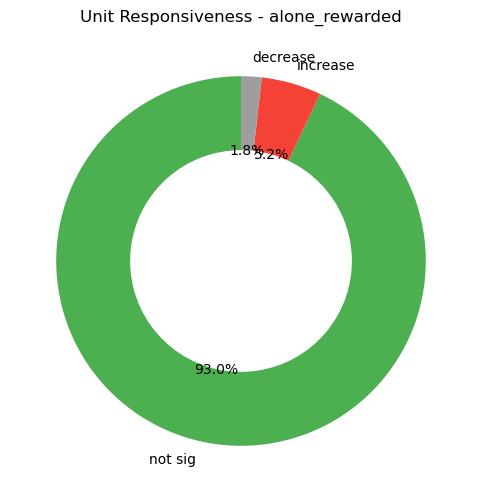

In [399]:
def plot_donut_pie(event_df, event_name):
    counts = event_df['sig'].value_counts()
    labels = counts.index
    sizes = counts.values
    colors = ['#4caf50', '#f44336', '#9e9e9e']  # green, red, gray

    fig, ax = plt.subplots(figsize=(6, 6))
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%',
                                      colors=colors[:len(labels)],
                                      startangle=90, wedgeprops=dict(width=0.4))

    ax.set_title(f"Unit Responsiveness - {event_name}")
    plt.show()

# Example usage:
plot_donut_pie(all_events_combined_df, 'alone_rewarded')


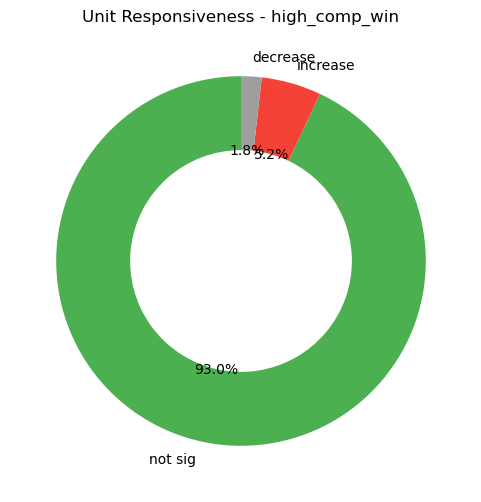

In [400]:
plot_donut_pie(all_events_combined_df, 'high_comp_win')


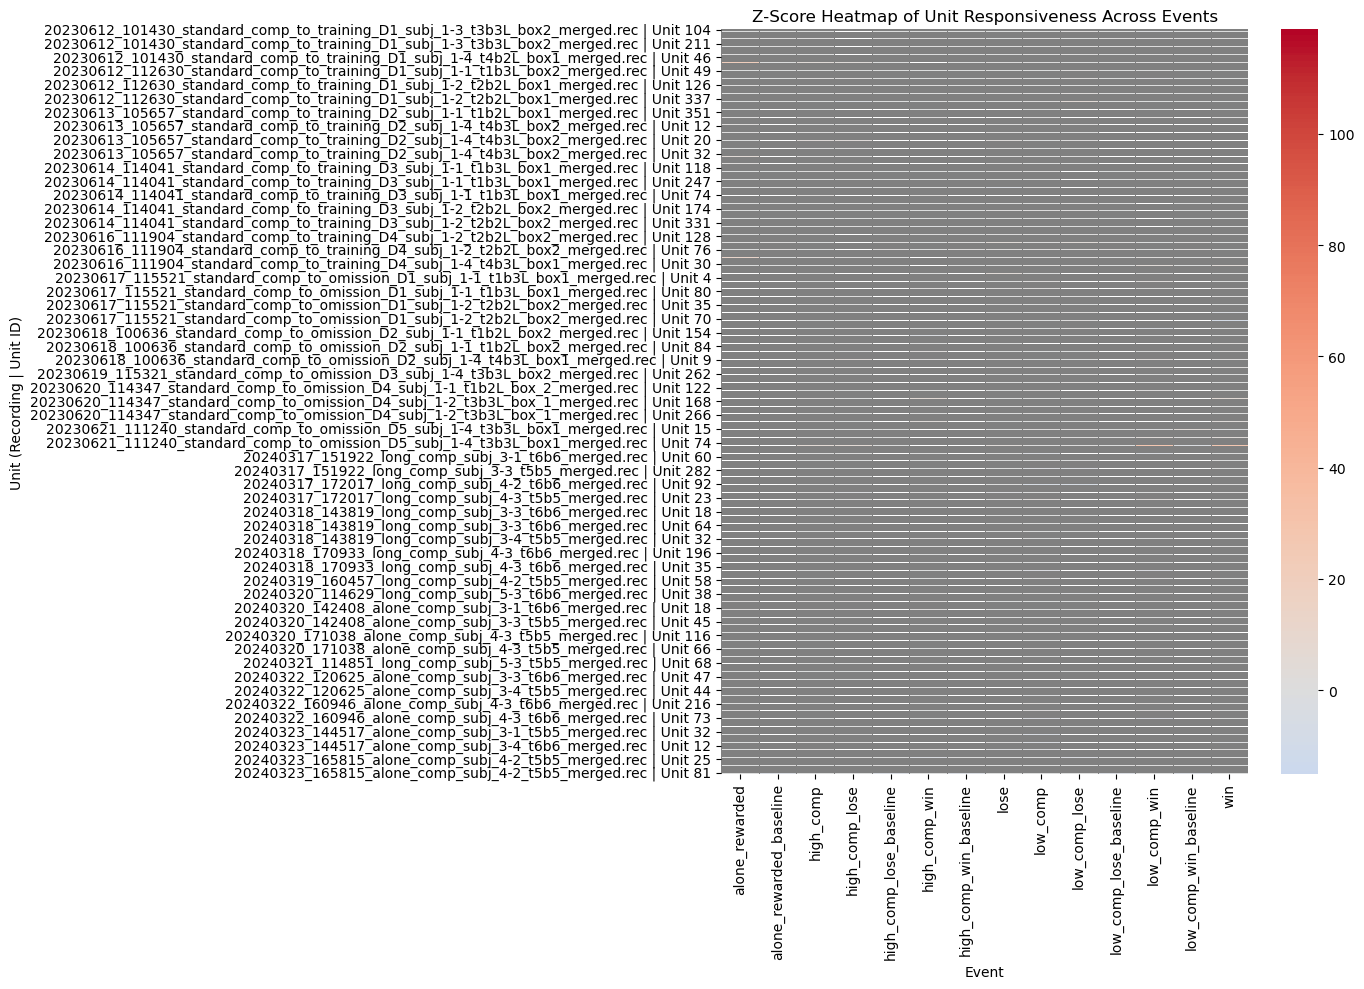

In [401]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List of events to analyze (excluding baseline/tone-prep events)
event_list = ['alone_rewarded', 'alone_rewarded_baseline', 'high_comp', 'high_comp_lose', 'high_comp_lose_baseline', 'high_comp_win', 'high_comp_win_baseline', 'lose', 'low_comp', 'low_comp_lose', 'low_comp_lose_baseline', 'low_comp_win', 'low_comp_win_baseline', 'win']


# Collect z-scores across events
zscore_dfs = []

for event in event_list:
    for recording in sp.recordings:
        if event in recording.event_dict:
            df = run_zscore_per_event(recording, event, pre_window=10, SD=1.65, verbose=False)
            if not df.empty:
                zscore_dfs.append(df)

# Combine all into one long DataFrame
all_zscores = pd.concat(zscore_dfs, ignore_index=True)

# Create a unique unit label (Recording + Unit) to distinguish across sessions
all_zscores['Unique Unit'] = all_zscores['Recording'] + ' | Unit ' + all_zscores['Unit number'].astype(str)

# Pivot to get units as rows, events as columns
pivot_df = all_zscores.pivot(index='Unique Unit', columns='Event name', values='Event Z-Score')

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_df, cmap='coolwarm', center=0, linewidths=0.5, linecolor='gray')
plt.title("Z-Score Heatmap of Unit Responsiveness Across Events")
plt.xlabel("Event")
plt.ylabel("Unit (Recording | Unit ID)")
plt.tight_layout()
plt.show()


c:\Users\thoma\miniconda3\envs\ephys_env\lib\site-packages\matplotlib_venn\layout\venn3\pairwise.py:103: UserWarning: Circle A has zero area.
  warnings.warn("Circle A has zero area.")
c:\Users\thoma\miniconda3\envs\ephys_env\lib\site-packages\matplotlib_venn\layout\venn3\pairwise.py:107: UserWarning: Circle B has zero area.
  warnings.warn("Circle B has zero area.")


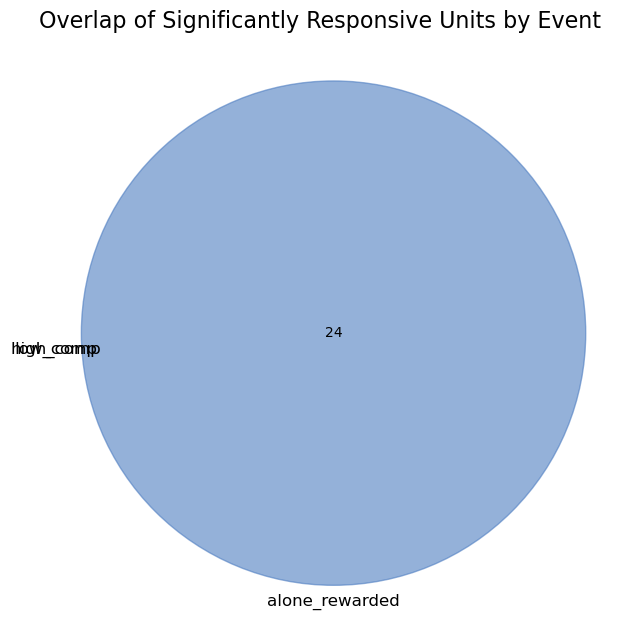

In [402]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3

# Step 1: Define the events you care about
# event_names = ['alone_rewarded', 'alone_rewarded_baseline', 'high_comp', 'high_comp_lose', 'high_comp_lose_baseline', 'high_comp_win', 'high_comp_win_baseline', 'lose', 'low_comp', 'low_comp_lose', 'low_comp_lose_baseline', 'low_comp_win', 'low_comp_win_baseline', 'win']


target_events = ['high_comp', 'low_comp', 'alone_rewarded']

# Step 2: Filter and collect significant units per event
event_sets = {event: set() for event in target_events}

for idx, row in combined_zscore_df.iterrows():
    if row['sig'] in ['increase', 'decrease']:  # only keep significant units
        event = row['Event name']
        if event in target_events:
            unique_id = (row['Recording'], row['Unit number'])  # uniquely identify unit across recordings
            event_sets[event].add(unique_id)

# Step 3: Extract sets in the same order
a = event_sets['high_comp']
b = event_sets['low_comp']
c = event_sets['alone_rewarded']

# Step 4: Plot Venn diagram
plt.figure(figsize=(8, 8))
v = venn3([a, b, c], set_labels=['high_comp', 'low_comp', 'alone_rewarded'])

# Optional: Set colors (same as in original script)
colors = {
    '100': '#003074',
    '010': '#551d0b',
    '001': '#4d7dc1',
    '110': '#2B2740',
    '101': '#27579B',
    '011': '#514D66',
    '111': '#3C5281'
}
for region, color in colors.items():
    patch = v.get_patch_by_id(region)
    if patch:
        patch.set_color(color)
        patch.set_alpha(0.6)

plt.title('Overlap of Significantly Responsive Units by Event', fontsize=16)
plt.show()
